# Notes

Similar feature sets as iteration 1, except that we remove records that are considered as outliers at least in one column.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

sns.set_context('talk')

In [2]:
FILE_NAME = 'iteration-1.csv' #'iteration-2.csv'

input_train_path = os.path.join(
    '..',
    'dataset',
    'research-iteration',
    'feature-engineering',
    FILE_NAME
)

df_train = pd.read_csv(input_train_path)
df_train.head()

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability_mainly_not_orderable,availability_mainly_orderable,address_-99,address_1,address_2,time_of_day_afternoon,time_of_day_early_morning,time_of_day_evening,onlineStatus_-99,onlineStatus_0
0,1,6.0,5.0,0.000,1.0,59.99,59.99,59.99,1.0,59.99,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,6.0,5.0,11.940,1.0,59.99,59.99,59.99,1.0,59.99,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,6.0,5.0,39.887,1.0,59.99,59.99,59.99,1.0,59.99,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,6.0,5.0,0.000,0.0,-99.00,-99.00,-99.00,0.0,-99.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,6.0,5.0,15.633,0.0,-99.00,-99.00,-99.00,0.0,-99.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_train.iloc[0]

sessionNo                                         1
startHour                                       6.0
startWeekday                                    5.0
duration                                        0.0
cCount                                          1.0
cMinPrice                                     59.99
cMaxPrice                                     59.99
cSumPrice                                     59.99
bCount                                          1.0
bMinPrice                                     59.99
bMaxPrice                                     59.99
bSumPrice                                     59.99
bStep                                         -99.0
onlineStatus                                    -99
availability                                    -99
customerNo                                      1.0
maxVal                                        600.0
customerScore                                  70.0
accountLifetime                                21.0
payments    

# Prepare training and test set

In [4]:
row_count_before = df_train.shape[0]
row_count_before

429013

In [5]:
## remove redundant features - we've done one hot encoding
## also remove ID columns: sessionNo, customerNo
df_train.drop(
    labels=["availability", "address", "time_of_day", "onlineStatus", "sessionNo", "customerNo"], 
    axis=1,
    inplace=True
)

## remove rows that contain outlier
mask_is_outlier_column = df_train.columns.str.endswith('_is_outlier')
is_outlier_column_list = df_train.columns[mask_is_outlier_column]

for col in is_outlier_column_list:
    mask_not_outlier = (df_train[col] == 0)
    df_train = df_train[mask_not_outlier].copy().reset_index(drop=True)
    
row_count_after = df_train.shape[0]
print(df_train.shape)

df_train.drop(
    labels=is_outlier_column_list,
    axis=1,
    inplace=True
)

(247167, 52)


In [6]:
## half of the records are removed due to outliers
row_count_after / row_count_before

0.5761293946803476

In [7]:
df_train.iloc[0]

startHour                                     6.00
startWeekday                                  5.00
duration                                      0.00
cCount                                        1.00
cMinPrice                                    59.99
cMaxPrice                                    59.99
cSumPrice                                    59.99
bCount                                        1.00
bMinPrice                                    59.99
bMaxPrice                                    59.99
bSumPrice                                    59.99
bStep                                       -99.00
maxVal                                      600.00
customerScore                                70.00
accountLifetime                              21.00
payments                                      1.00
age                                          43.00
lastOrder                                    49.00
order                                         1.00
availability_-99               

In [8]:
categorical_feature_list = [
    'availability_-99', 'availability_completely_not_determinable',
    'availability_completely_not_orderable','availability_completely_orderable',
    'availability_mainly_not_determinable','availability_mainly_not_orderable', 
    'availability_mainly_orderable',
    'address_-99', 'address_1', 'address_2', 
    'time_of_day_afternoon','time_of_day_early_morning', 'time_of_day_evening', 
    'onlineStatus_-99','onlineStatus_0'
]

for col in categorical_feature_list:
    df_train[col] = df_train[col].astype(int)

In [9]:
## train test split (using original data, without handling imbalanced class distribution)
from sklearn.model_selection import train_test_split

TEST_PROPORTION = 0.3
RND = 121
target_class = 'order'
features = df_train.columns[(df_train.columns != target_class)]

X_train, X_test, y_train, y_test = train_test_split(
    df_train[features], 
    df_train[target_class],
    test_size=TEST_PROPORTION,
    random_state=RND
)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(173016, 33) (173016,)
(74151, 33) (74151,)


In [11]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_auc_score

def evaluate_performance(y_true, y_pred, print_results = True):
    accuracy = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    if print_results:
        print(f"Accuracy : {accuracy:.3%}")
        print(f"F1-score : {f_score:.3%}")
        print(f"AUC: {auc:.3f}")
        print(classification_report(y_true, y_pred))
        
    return accuracy, f_score, auc

In [12]:
from sklearn.model_selection import KFold

def kfold_cv(clf, X_train, y_train, k = 10):
    kfold = KFold(random_state = RND, shuffle = True, n_splits = k)
    
    cv_accuracy = np.zeros(shape=k)
    cv_f1 = np.zeros(shape=k)
    cv_auc = np.zeros(shape=k)
    
    i = 0
    for train_index, val_index in kfold.split(X_train):
        X_tr = X_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        X_val = X_train.loc[val_index]
        y_val = y_train.loc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        accuracy, f_score, auc = evaluate_performance(y_val, y_pred, print_results = False)
        print(f"Iteration {i+1}: Accuracy={accuracy:.3%} | F1-score={f_score:.3%} | AUC={auc:.3f}")
        
        cv_accuracy[i] = accuracy
        cv_f1[i] = f_score
        cv_auc[i] = auc
        
        i += 1
    
    print("Cross-validation results")
    print("========================")
    print(f"Accuracy: {np.mean(cv_accuracy):.3%} +- {np.std(cv_accuracy):.3%}")
    print(f"F1-score: {np.mean(cv_f1):.3%} +- {np.std(cv_f1):.3%}")
    print(f"AUC: {np.mean(cv_auc):.3f} +- {np.std(cv_auc):.3f}")

# Model Training and Evaluation

## Baseline: Logistic Regression without fine-tuning

In [13]:
from sklearn.linear_model import LogisticRegression

model_logres = LogisticRegression(random_state=RND, max_iter=200, solver='saga', penalty='elasticnet', l1_ratio=0.2)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_logres, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_logres.fit(X_train, y_train)

/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 1: Accuracy=72.694% | F1-score=81.385% | AUC=0.642


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 2: Accuracy=73.719% | F1-score=82.167% | AUC=0.651


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 3: Accuracy=73.260% | F1-score=81.847% | AUC=0.646


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 4: Accuracy=73.650% | F1-score=82.115% | AUC=0.651


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 5: Accuracy=72.971% | F1-score=81.582% | AUC=0.645
Cross-validation results
Accuracy: 73.259% +- 0.392%
F1-score: 81.819% +- 0.301%
AUC: 0.647 +- 0.003


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(l1_ratio=0.2, max_iter=200, penalty='elasticnet',
                   random_state=121, solver='saga')

In [14]:
y_pred = model_logres.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 73.284%
F1-score : 81.847%
AUC: 0.647
              precision    recall  f1-score   support

           0       0.60      0.42      0.49     22992
           1       0.77      0.87      0.82     51159

    accuracy                           0.73     74151
   macro avg       0.68      0.65      0.66     74151
weighted avg       0.72      0.73      0.72     74151



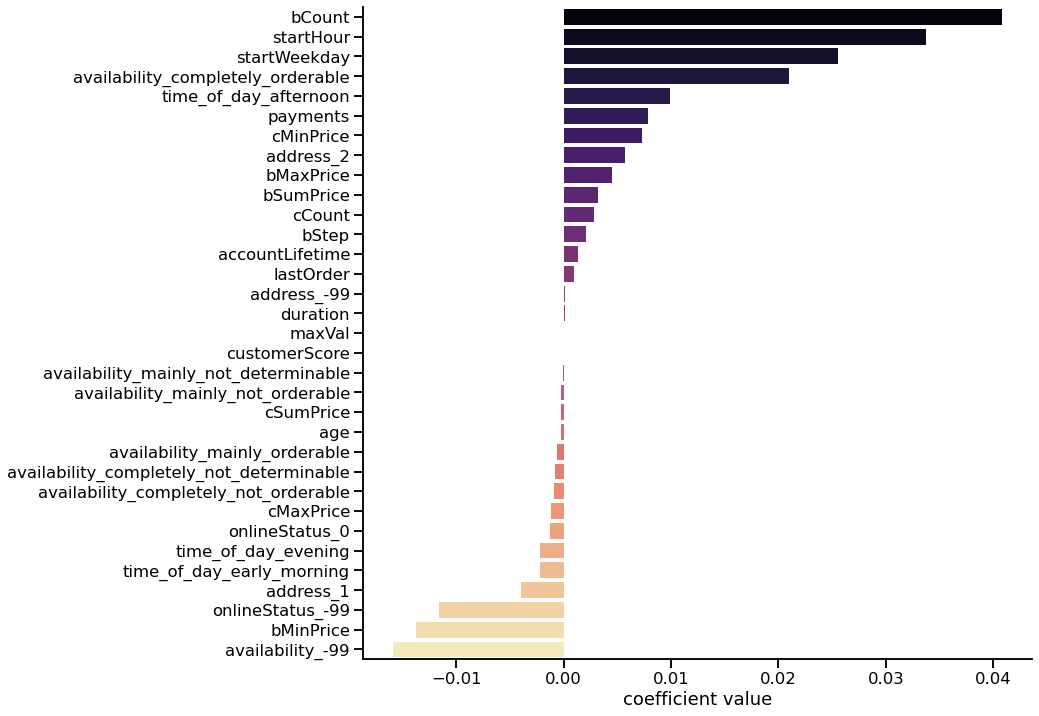

In [15]:
logres_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_logres.coef_[0]
    }
).sort_values(by='coef', ascending=False)
logres_coef['coef_abs'] = np.abs(logres_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=logres_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=RND)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_rf, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_rf.fit(X_train, y_train)

Iteration 1: Accuracy=87.834% | F1-score=91.401% | AUC=0.840
Iteration 2: Accuracy=88.059% | F1-score=91.615% | AUC=0.842
Iteration 3: Accuracy=88.391% | F1-score=91.798% | AUC=0.847
Iteration 4: Accuracy=88.221% | F1-score=91.712% | AUC=0.845
Iteration 5: Accuracy=88.108% | F1-score=91.603% | AUC=0.843
Cross-validation results
Accuracy: 88.122% +- 0.184%
F1-score: 91.626% +- 0.133%
AUC: 0.843 +- 0.002


RandomForestClassifier(random_state=121)

In [17]:
y_pred = model_rf.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 88.929%
F1-score : 92.163%
AUC: 0.856
              precision    recall  f1-score   support

           0       0.86      0.77      0.81     22992
           1       0.90      0.94      0.92     51159

    accuracy                           0.89     74151
   macro avg       0.88      0.86      0.87     74151
weighted avg       0.89      0.89      0.89     74151



In [18]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 121,
 'verbose': 0,
 'warm_start': False}

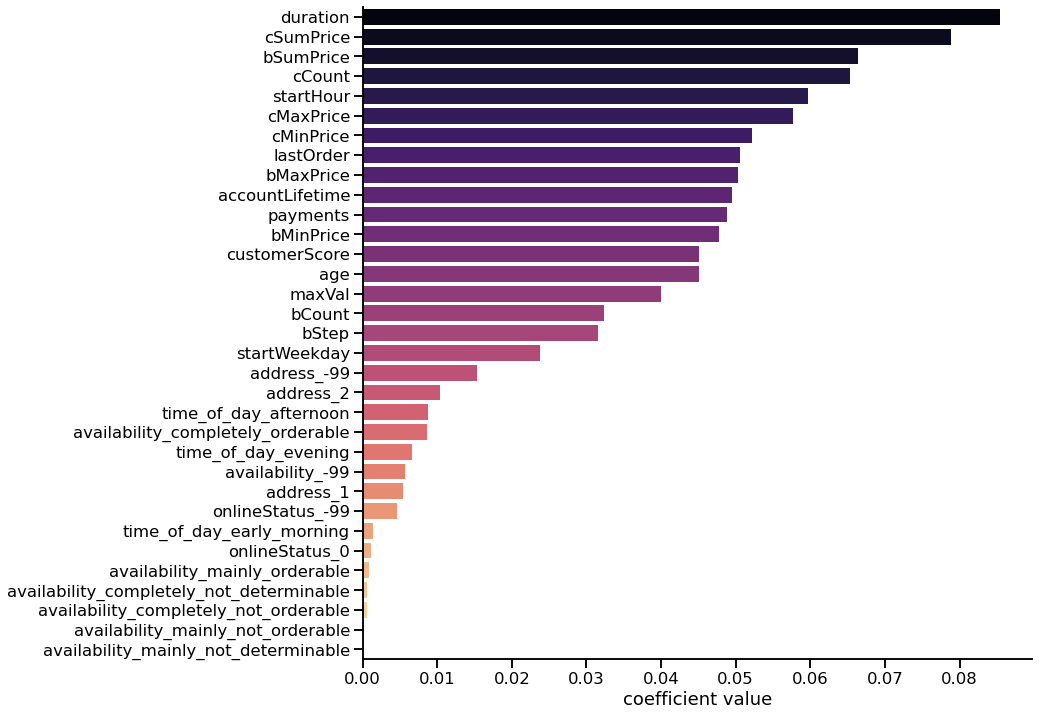

In [19]:
rf_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_rf.feature_importances_
    }
).sort_values(by='coef', ascending=False)
rf_coef['coef_abs'] = np.abs(rf_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=rf_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# LightGBM

In [20]:
import lightgbm as lgbm

model_lgbm = lgbm.LGBMClassifier(
    random_state=RND,
    objective='binary',
    learning_rate=0.2,
    subsample=0.7,
    subsample_freq=3,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_lgbm, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_lgbm.fit(X_train, y_train, categorical_feature=categorical_feature_list)

Iteration 1: Accuracy=78.907% | F1-score=85.443% | AUC=0.722
Iteration 2: Accuracy=79.779% | F1-score=86.139% | AUC=0.729
Iteration 3: Accuracy=79.661% | F1-score=86.011% | AUC=0.729
Iteration 4: Accuracy=79.869% | F1-score=86.158% | AUC=0.732
Iteration 5: Accuracy=79.759% | F1-score=86.048% | AUC=0.731
Cross-validation results
Accuracy: 79.595% +- 0.350%
F1-score: 85.960% +- 0.264%
AUC: 0.729 +- 0.004


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.2, objective='binary',
               random_state=121, reg_alpha=0.1, reg_lambda=0.1, subsample=0.7,
               subsample_freq=3)

In [21]:
model_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.2,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 121,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'silent': True,
 'subsample': 0.7,
 'subsample_for_bin': 200000,
 'subsample_freq': 3}

In [22]:
y_pred = model_lgbm.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 79.612%
F1-score : 85.974%
AUC: 0.729
              precision    recall  f1-score   support

           0       0.72      0.55      0.63     22992
           1       0.82      0.91      0.86     51159

    accuracy                           0.80     74151
   macro avg       0.77      0.73      0.74     74151
weighted avg       0.79      0.80      0.79     74151



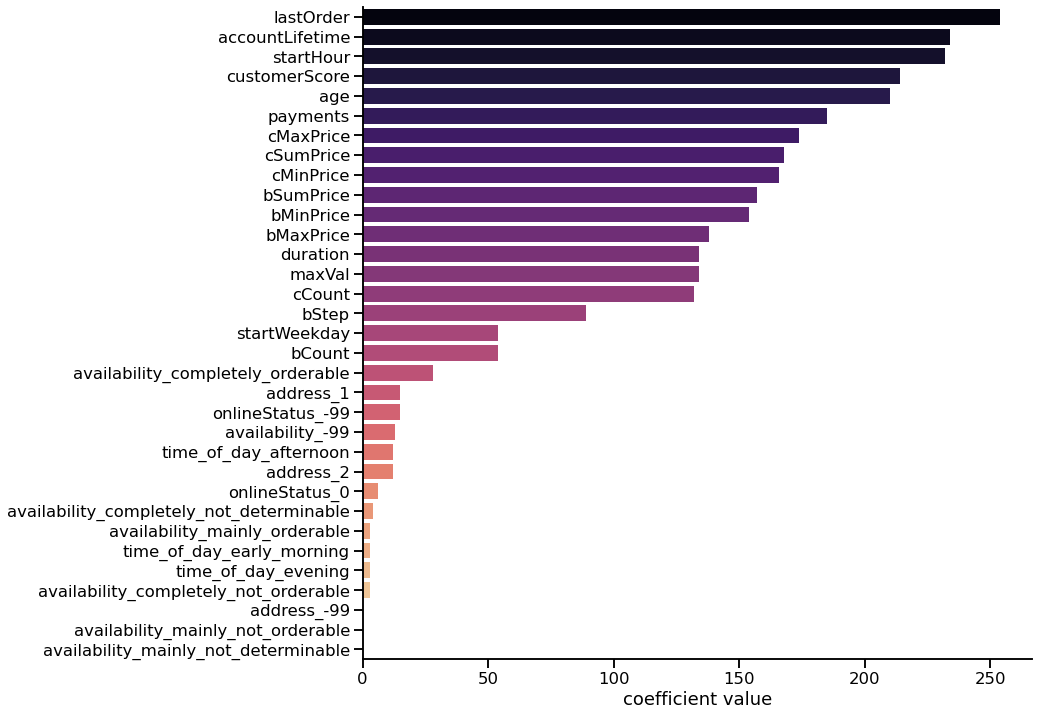

In [23]:
lgbm_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_lgbm.feature_importances_
    }
).sort_values(by='coef', ascending=False)
lgbm_coef['coef_abs'] = np.abs(lgbm_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=lgbm_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# Catboost

In [24]:
from catboost import CatBoostClassifier

## https://catboost.ai/en/docs/concepts/parameter-tuning
model_catboost = CatBoostClassifier(
    iterations=100,
    learning_rate=0.2,
    max_depth=10,
    l2_leaf_reg=0.1,
    random_state=RND
)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_catboost, X_train, y_train, k=KFOLD_ITER)

## Fit model
model_catboost.fit(X_train, y_train, cat_features=categorical_feature_list)
# # Get predicted classes
# preds_class = model_catboost.predict(eval_data)
# # Get predicted probabilities for each class
# preds_proba = model_catboost.predict_proba(eval_data)
# # Get predicted RawFormulaVal
# preds_raw = model_catboost.predict(eval_data, prediction_type='RawFormulaVal')

0:	learn: 0.6202048	total: 283ms	remaining: 28s
1:	learn: 0.5745339	total: 471ms	remaining: 23.1s
2:	learn: 0.5445478	total: 584ms	remaining: 18.9s
3:	learn: 0.5272859	total: 653ms	remaining: 15.7s
4:	learn: 0.5127600	total: 729ms	remaining: 13.9s
5:	learn: 0.5031418	total: 808ms	remaining: 12.7s
6:	learn: 0.4971735	total: 888ms	remaining: 11.8s
7:	learn: 0.4890789	total: 962ms	remaining: 11.1s
8:	learn: 0.4845380	total: 1.04s	remaining: 10.5s
9:	learn: 0.4804497	total: 1.12s	remaining: 10.1s
10:	learn: 0.4775025	total: 1.21s	remaining: 9.8s
11:	learn: 0.4713126	total: 1.31s	remaining: 9.6s
12:	learn: 0.4669845	total: 1.39s	remaining: 9.32s
13:	learn: 0.4643121	total: 1.47s	remaining: 9.05s
14:	learn: 0.4620239	total: 1.56s	remaining: 8.85s
15:	learn: 0.4569862	total: 1.65s	remaining: 8.64s
16:	learn: 0.4543076	total: 1.73s	remaining: 8.44s
17:	learn: 0.4532009	total: 1.82s	remaining: 8.28s
18:	learn: 0.4507141	total: 1.9s	remaining: 8.1s
19:	learn: 0.4472491	total: 1.98s	remaining: 7.

In [25]:
model_catboost.get_params()

{'iterations': 100,
 'learning_rate': 0.2,
 'l2_leaf_reg': 0.1,
 'max_depth': 10,
 'random_state': 121}

In [26]:
y_pred = model_catboost.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 83.778%
F1-score : 88.648%
AUC: 0.789
              precision    recall  f1-score   support

           0       0.78      0.66      0.72     22992
           1       0.86      0.92      0.89     51159

    accuracy                           0.84     74151
   macro avg       0.82      0.79      0.80     74151
weighted avg       0.83      0.84      0.83     74151



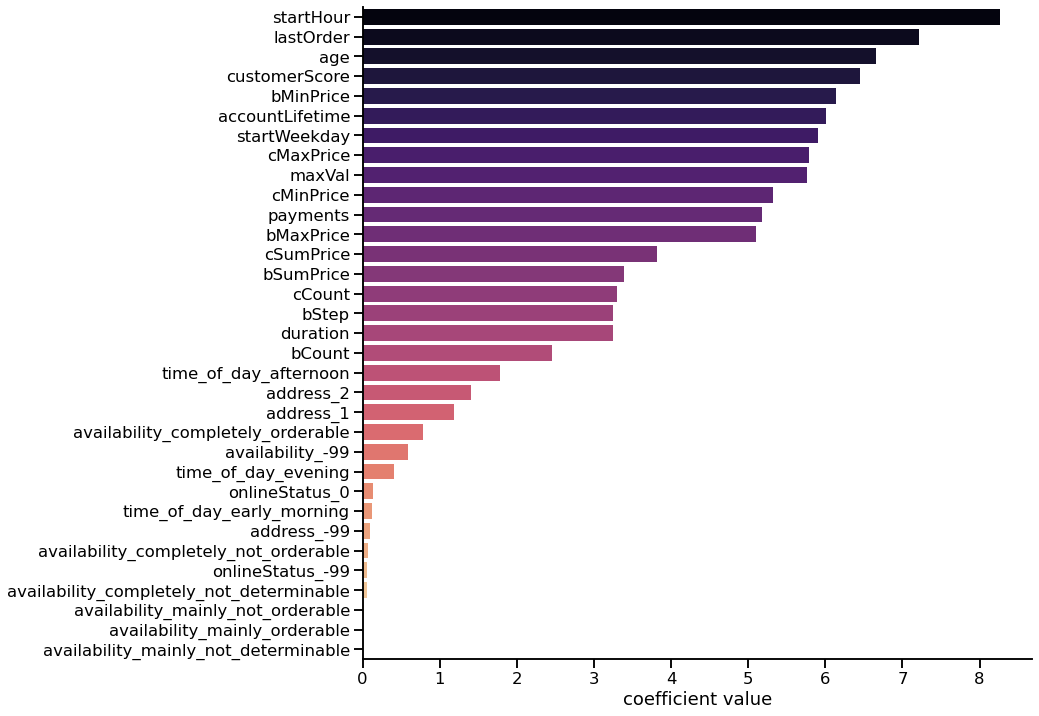

In [27]:
catboost_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_catboost.feature_importances_
    }
).sort_values(by='coef', ascending=False)
catboost_coef['coef_abs'] = np.abs(catboost_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=catboost_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();